In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import stumpy
from sklearn.preprocessing import StandardScaler
from dao import DataLoading
from matplotlib.patches import Rectangle
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA

In [38]:
def visualize_data(datafilename,data):
    fig,ax = plt.subplots(1,1,figsize = (15,15))
    test_data_start_pt = int(re.findall(r'[0-9]*.txt',datafilename)[0].split('.')[0])
    datasize = len(data)
    ax.plot(list(range(0,test_data_start_pt)),data[:test_data_start_pt],'b')
    ax.plot(list(range(test_data_start_pt,datasize)),data[test_data_start_pt:datasize],'r')


In [39]:
def return_normal_anoalous_data(datafilename,data):
    test_data_start_pt = int(re.findall(r'[0-9]*.txt',datafilename)[0].split('.')[0])
    return data[:test_data_start_pt], data[test_data_start_pt:len(data)]

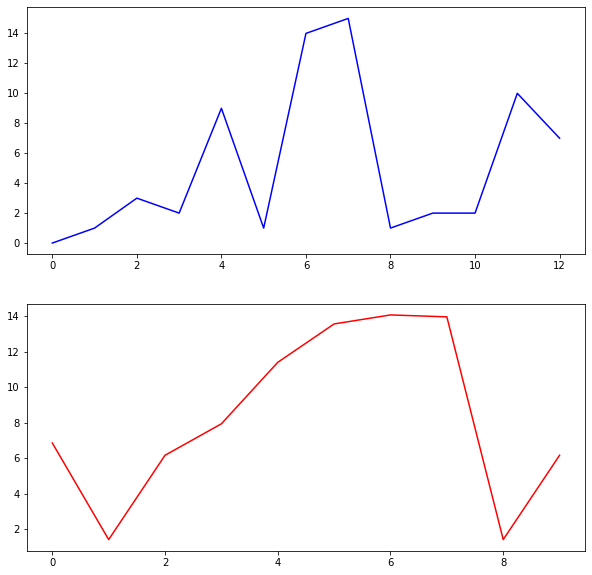

In [40]:
from dao import matrixprofile_bruteforce
import matplotlib.pyplot as plt
time_series = [0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7]
n = len(time_series)
m = 4

results_dict = matrixprofile_bruteforce.calculate_matrix_profile(time_series,m)
fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(range(len(time_series)),time_series, color = 'b')
ax[1].plot([i for i in results_dict],[results_dict[i] for i in results_dict], color = 'r')

In [41]:
len(os.listdir(DataLoading.file_path))

251

<h1>Matrix Profile</h1>

In [42]:
#using A-B join
results_dict = dict()
m = 100
for i in range(1,51):
    print(i)
    #lengthtuple = len_list[i - 1]
    train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = i)
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    #to select the window to be used we need to find the minimum length of the test and train sets
    #min_len = min(lengthtuple)
    #m = [np.floor(min_len/200),np.floor(min_len/100),np.floor(min_len/50),np.floor(min_len/20)
    mp = stumpy.stump(test_scaled.reshape(test_scaled.shape[0],),m,train_scaled.reshape(train_scaled.shape[0],),ignore_trivial=False,normalize=False)
    position_of_firstanomaly = np.argsort(mp[:,0])[-1]
    position_of_secondanomaly = np.argsort(mp[:,0])[-2]
    score_of_firstanomaly = sorted(mp[:,0],reverse=True)[0]
    score_of_secondanomaly = sorted(mp[:,0],reverse=True)[1]
    #first anomaly,second anomaly
    results_dict[i] = [position_of_firstanomaly + test_data_start_pt,position_of_secondanomaly + test_data_start_pt,score_of_firstanomaly,score_of_secondanomaly]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [43]:
idx = list(results_dict.keys())
outlier = [results_dict[i] for i in results_dict]
matrix_profile_50 = pd.DataFrame(data= np.array(outlier))
matrix_profile_50.to_csv('Matrix_Profile_50.csv')

In [44]:
idx = list(results_dict.keys())
first_outlier = [results_dict[i][0] for i in results_dict]
second_outlier = [results_dict[i][1] for i in results_dict]
first_outlier_peak = [results_dict[i][2] for i in results_dict]
second_outlier_peak = [results_dict[i][3] for i in results_dict]
data = dict()
data["First"] = first_outlier
data["First Peak"] = first_outlier_peak
data["Second"] = second_outlier
data["Second Peak"] = second_outlier_peak
matrix_profile_50 = pd.DataFrame(data= data)
matrix_profile_50.to_csv('Matrix_Profile_50_50.csv')

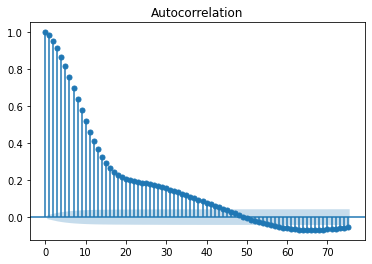

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 1)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
plot_acf(train_scaled,lags = 75)
plt.show()

In [46]:
num_datasets = len(os.listdir(DataLoading.file_path))
results_dict_autoreg = dict()
for idx in range(1,51):
    train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = idx)
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)

    window = 100
    model = AutoReg(train_scaled,lags = window)
    model_fit = model.fit()
    coef = model_fit.params
    history = train_scaled[len(train_scaled) - window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    mean_sq_err = list()
    for t in range(len(test_scaled)):
        length = len(history)
        lag = [history[i] for i in range(length - window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window - d - 1]
        new_history = test_scaled[t]
        predictions.append(yhat)
        history.append(new_history)
        mean_sq_err.append((t + test_data_start_pt,np.abs(new_history,yhat)))
    scores = sorted(mean_sq_err, key = lambda x:x[1],reverse=True)
    results_dict_autoreg[idx] = [scores[0][0],scores[0][1],scores[1][0],scores[1][1]]

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names wil

In [47]:
first_outlier_mp = [results_dict[i][0] for i in results_dict]
second_outlier_mp = [results_dict[i][1] for i in results_dict]
prominence_mp = [results_dict[i][2]/results_dict[i][3] for i in results_dict]
first_outlier_autoreg = [results_dict_autoreg[i][0] for i in results_dict_autoreg]
second_outlier_autoreg = [results_dict_autoreg[i][2] for i in results_dict_autoreg]
prominence_autoreg = [results_dict_autoreg[i][1]/results_dict_autoreg[i][3] for i in results_dict_autoreg]
data = {"First Outlier_MP":first_outlier_mp,"Second Outlier_MP":second_outlier_mp,"Prominence_MP":prominence_mp,"First Outlier Autoreg":first_outlier_autoreg,"Second Outlier Autoreg":second_outlier_autoreg,"Prominence Autoreg":prominence_autoreg}

df_results = pd.DataFrame(data)
df_results

,First Outlier_MP,Second Outlier_MP,Prominence_MP,First Outlier Autoreg,Second Outlier Autoreg,Prominence Autoreg
0,66860,66859,1.001198,66888,66889,[1.0014381148975697]
1,67065,67066,1.002193,67095,67094,[1.0106584936367522]
2,67063,67062,1.000494,67094,67093,[1.0087976675542973]
3,5500,5499,1.000038,5590,5591,[1.005867001165952]
4,4686,4687,1.010447,6253,6252,[1.004964462661783]
5,4738,4739,1.005688,5101,5100,[1.0023530483983119]
6,4740,4741,1.003397,5078,5079,[1.0050022543236434]
7,4729,4730,1.000653,4791,4790,[1.0187217175438543]
8,4790,4789,1.001218,6253,5078,[1.0016857385777582]
9,5984,5985,1.000271,5101,5100,[1.0098990092228206]


' axs.set_ylabel(\'Y\')\nrect = Rectangle((156896, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor=\'lightgrey\')\naxs.add_patch(rect)\nrect1 = Rectangle((17099, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor=\'lightgrey\')\naxs.add_patch(rect1)\naxs.axvline(x = np.array(train).shape[0], linestyle = "dashed")\naxs.axvline(x = (156896 + 25),linestyle = "dashed",color = \'g\')\naxs.axvline(x = (17099 + 25),linestyle = "dashed",color = \'r\') '

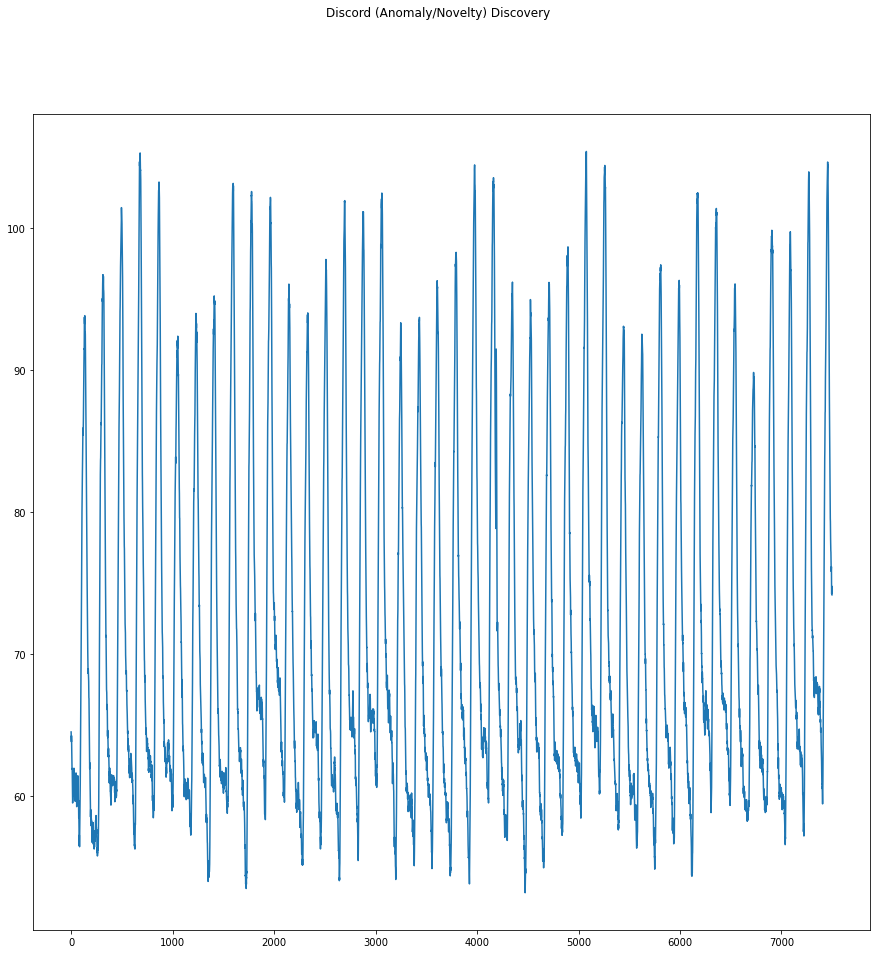

In [8]:
fig, axs = plt.subplots(1, figsize = (15,15), sharex=True, gridspec_kw={'hspace': 0})
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 30)
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs.plot(np.concatenate((train,test)))
""" axs.set_ylabel('Y')
rect = Rectangle((156896, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect)
rect1 = Rectangle((17099, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect1)
axs.axvline(x = np.array(train).shape[0], linestyle = "dashed")
axs.axvline(x = (156896 + 25),linestyle = "dashed",color = 'g')
axs.axvline(x = (17099 + 25),linestyle = "dashed",color = 'r') """

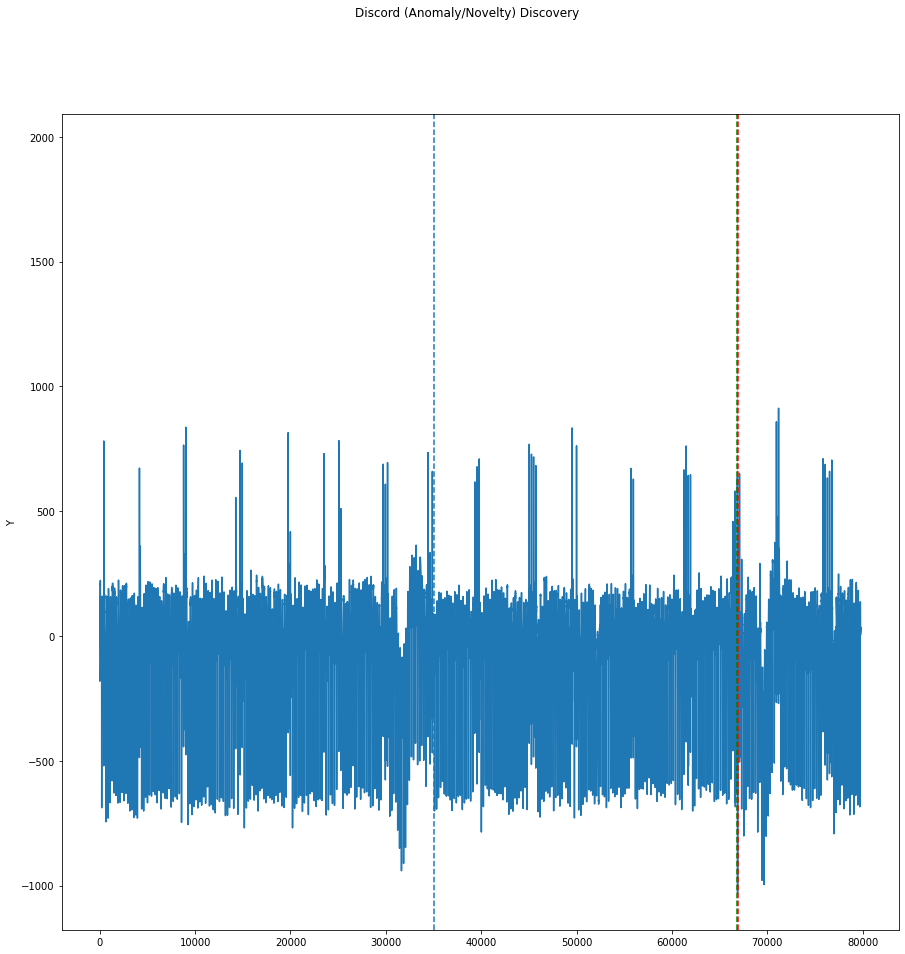

In [55]:
fig, axs = plt.subplots(1, figsize = (15,15), sharex=True, gridspec_kw={'hspace': 0})
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 1)
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs.plot(np.concatenate((train,test)))
axs.set_ylabel('Y')
rect = Rectangle((66860, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect)
rect1 = Rectangle((66888, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect1)
axs.axvline(x = np.array(train).shape[0], linestyle = "dashed")
axs.axvline(x = (66860),linestyle = "dashed",color = 'g')
axs.axvline(x = (66888),linestyle = "dashed",color = 'r')

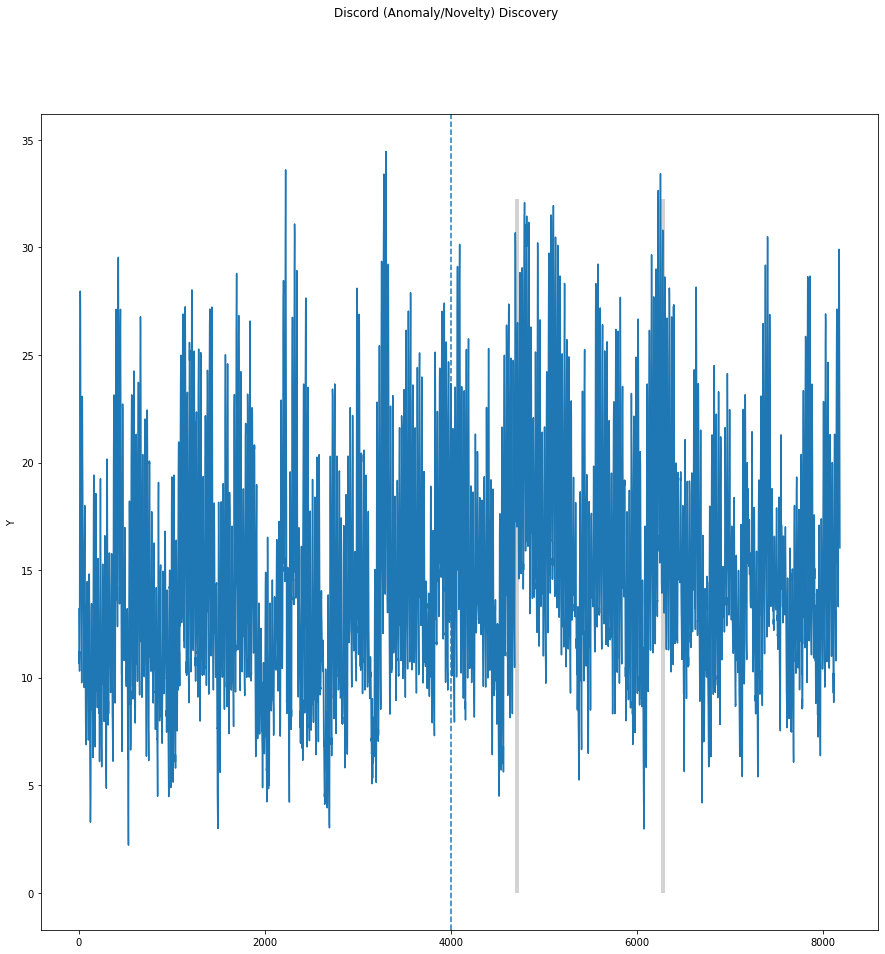

In [58]:
fig, axs = plt.subplots(1, figsize = (15,15), sharex=True, gridspec_kw={'hspace': 0})
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 5)
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs.plot(np.concatenate((train,test)))
axs.set_ylabel('Y')
rect = Rectangle((4686, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect)
rect1 = Rectangle((6253, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect1)
axs.axvline(x = np.array(train).shape[0], linestyle = "dashed")
#axs.axvline(x = (6253 + 25),linestyle = "dashed",color = 'g')
#axs.axvline(x = (4686 + 25),linestyle = "dashed",color = 'r')

In [51]:
#using Self Join matrix profile
#using A-B join
results_dict_selfjoin = dict()
m = 100
for i in range(1,51):
    print(i)
    #lengthtuple = len_list[i - 1]
    train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = i)
    data_test_train = np.concatenate((train,test))
    data_test_train = np.array(data_test_train).reshape(-1,1)
    scaler = StandardScaler()
    data_test_train = scaler.fit_transform(data_test_train)
    #to select the window to be used we need to find the minimum length of the test and train sets
    #min_len = min(lengthtuple)
    #m = [np.floor(min_len/200),np.floor(min_len/100),np.floor(min_len/50),np.floor(min_len/20)
    mp = stumpy.stump(data_test_train.reshape(data_test_train.shape[0],),m = m,ignore_trivial=True,normalize=False)
    position_of_firstanomaly = np.argsort(mp[:,0])[-1]
    position_of_secondanomaly = np.argsort(mp[:,0])[-2]
    score_of_firstanomaly = sorted(mp[:,0],reverse=True)[0]
    score_of_secondanomaly = sorted(mp[:,0],reverse=True)[1]
    #first anomaly,second anomaly
    results_dict_selfjoin[i] = [position_of_firstanomaly,position_of_secondanomaly,score_of_firstanomaly,score_of_secondanomaly]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [52]:
first_outlier_mp = [results_dict[i][0] for i in results_dict]
second_outlier_mp = [results_dict[i][1] for i in results_dict]
prominence_mp = [results_dict[i][2]/results_dict[i][3] for i in results_dict]
first_outlier_autoreg = [results_dict_autoreg[i][0] for i in results_dict_autoreg]
second_outlier_autoreg = [results_dict_autoreg[i][2] for i in results_dict_autoreg]
prominence_autoreg = [results_dict_autoreg[i][1]/results_dict_autoreg[i][3] for i in results_dict_autoreg]
first_outlier_selfjoin = [results_dict_selfjoin[i][0] for i in results_dict_selfjoin]
second_outlier_selfjoin = [results_dict_selfjoin[i][1] for i in results_dict_selfjoin]
prominence_selfjoin = [results_dict_selfjoin[i][2]/results_dict_selfjoin[i][3] for i in results_dict_selfjoin]
data = {"First Outlier_MP":first_outlier_mp,"Second Outlier_MP":second_outlier_mp,"Prominence_MP":prominence_mp,"First Outlier Autoreg":first_outlier_autoreg,"Second Outlier Autoreg":second_outlier_autoreg,"Prominence Autoreg":prominence_autoreg,"First Outlier self join MP":first_outlier_selfjoin,"Second Outlier self join MP":second_outlier_selfjoin,"Prominence self join mp":prominence_selfjoin}

df_results = pd.DataFrame(data)
df_results

,First Outlier_MP,Second Outlier_MP,Prominence_MP,First Outlier Autoreg,Second Outlier Autoreg,Prominence Autoreg,First Outlier self join MP,Second Outlier self join MP,Prominence self join mp
0,66860,66859,1.001198,66888,66889,[1.0014381148975697],66872,66871,1.000378
1,67065,67066,1.002193,67095,67094,[1.0106584936367522],67077,67076,1.000060
2,67063,67062,1.000494,67094,67093,[1.0087976675542973],67076,67075,1.000295
3,5500,5499,1.000038,5590,5591,[1.005867001165952],5499,5500,1.000738
4,4686,4687,1.010447,6253,6252,[1.004964462661783],2215,2214,1.001538
5,4738,4739,1.005688,5101,5100,[1.0023530483983119],5668,5669,1.000647
6,4740,4741,1.003397,5078,5079,[1.0050022543236434],6517,6518,1.002874
7,4729,4730,1.000653,4791,4790,[1.0187217175438543],2191,2190,1.001415
8,4790,4789,1.001218,6253,5078,[1.0016857385777582],4833,4834,1.002044
9,5984,5985,1.000271,5101,5100,[1.0098990092228206],5975,5976,1.000899


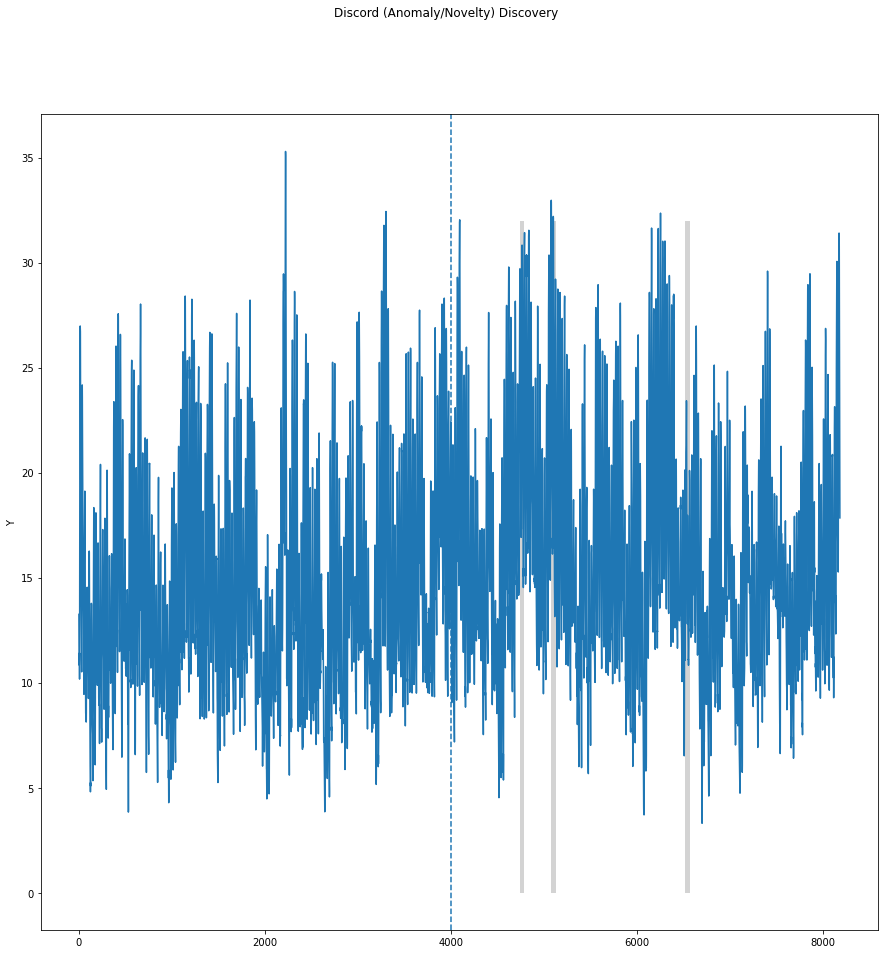

In [60]:
fig, axs = plt.subplots(1, figsize = (15,15), sharex=True, gridspec_kw={'hspace': 0})
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 7)
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs.plot(np.concatenate((train,test)))
axs.set_ylabel('Y')
rect = Rectangle((4740, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect)
rect1 = Rectangle((5078, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect1)
rect2 = Rectangle((6517, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect2)
axs.axvline(x = np.array(train).shape[0], linestyle = "dashed")
#axs.axvline(x = (4740 + 25),linestyle = "dashed",color = 'g')
#axs.axvline(x = (5078 + 25),linestyle = "dashed",color = 'r')
#axs.axvline(x = (6517 + 25),linestyle = "dashed",color = 'k')

In [53]:
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 1)
data_test_train = np.concatenate((train,test))
data_test_train.shape

(79794,)

In [54]:
data_test_train.reshape(data_test_train.shape[0],).shape

(79794,)

In [ ]:
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = idx)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
arima = pm.auto_arima(train_scaled,start_p = 50, )

<h2> AR and MA models </h2>

Prior to deciding for ARMA or ARIMA, we need to check if our datasets are stationary or not. To do this we use the Augmented Dicky Fuller Test. The null hypothesis is that the data is non-stationary. If the p value of the result is less than 0.05 we decide it is stationary.

Format of output from adfuller in statsmodel is (ADF Statistic, pvalue, lags used,number of observations used, critical values)

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [2]:
#investigating whether all the datasets are stationary or not
num_datasets = len(os.listdir(DataLoading.file_path))
adfuller_results = dict()
adfuller_results["ADF Statistic"] = list()
adfuller_results["P value"] = list()
adfuller_results["Stationary"] = list()
adfuller_results["Lags used"] = list()
adfuller_results["1% Statistic"] = list()
adfuller_results["5% Statistic"] = list()
adfuller_results["10% Statistic"] = list()
for i in range(1,221,10):
    print(i)
    train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = i)
    data = np.concatenate((train,test)).reshape(-1,1)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    result = adfuller(data,autolag='AIC')
    adfuller_results["ADF Statistic"].append(result[0])
    adfuller_results["P value"].append(result[1])
    if result[1] < 0.05:
        adfuller_results["Stationary"].append(True)
    else: 
        adfuller_results["Stationary"].append(False)
    adfuller_results["Lags used"].append(result[2])
    adfuller_results["1% Statistic"].append(result[4]["1%"])
    adfuller_results["5% Statistic"].append(result[4]["5%"])
    adfuller_results["10% Statistic"].append(result[4]["10%"])

adfuller_results_df = pd.DataFrame(adfuller_results)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211


In [3]:
adfuller_results_df

,ADF Statistic,P value,Stationary,Lags used,1% Statistic,5% Statistic,10% Statistic
0,-31.135457,0.000000e+00,True,63,-3.430432,-2.861576,-2.566789
1,-30.311115,0.000000e+00,True,50,-3.430568,-2.861637,-2.566821
2,-12.417765,4.203032e-23,True,33,-3.430897,-2.861782,-2.566899
3,-11.920863,5.036201e-22,True,36,-3.431227,-2.861927,-2.566976
4,-18.391657,2.200207e-30,True,50,-3.430570,-2.861637,-2.566822
5,-21.371618,0.000000e+00,True,40,-3.430926,-2.861795,-2.566906
6,-27.037520,0.000000e+00,True,61,-3.430451,-2.861585,-2.566794
7,-35.969295,0.000000e+00,True,58,-3.430469,-2.861593,-2.566798
8,-45.853811,0.000000e+00,True,80,-3.430384,-2.861555,-2.566778
9,-43.166574,0.000000e+00,True,72,-3.430401,-2.861562,-2.566782


In [4]:
adfuller_results_df.to_csv("Stationary Results.csv")

Above representative datasets shows that the datasets are stationary as all the AD FUller tests have pvalues lower than 0.05.

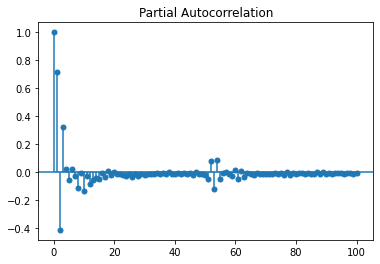

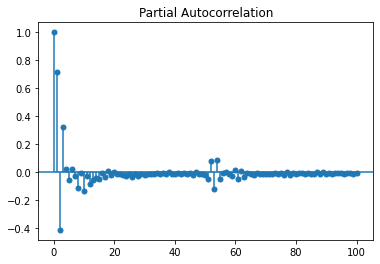

In [15]:
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 1)
data = np.concatenate((train,test)).reshape(-1,1)
scaler = StandardScaler()
data = scaler.fit_transform(data)
plot_pacf(pd.DataFrame(data = data)[0].diff()[1:],lags = 100)

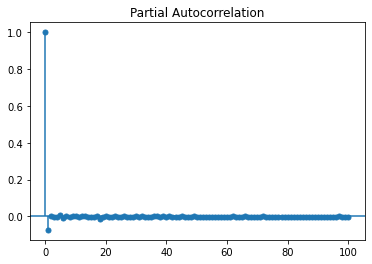

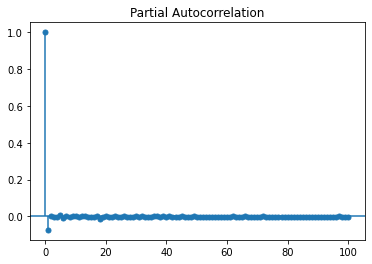

In [17]:
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 241)
data = np.concatenate((train,test)).reshape(-1,1)
scaler = StandardScaler()
data = scaler.fit_transform(data)
plot_pacf(pd.DataFrame(data = data)[0].diff()[1:],lags = 100)

In [34]:
#https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
import statsmodels.api as sm
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 1)
data = np.concatenate((train,test)).reshape(-1,1)
scaler = StandardScaler()
data = scaler.fit_transform(data)
test_data = scaler.

In [35]:
acf, ci_acf= sm.tsa.acf(data,alpha=0.05)
pacf, ci_pacf = sm.tsa.pacf(data,alpha=0.05)

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


In [36]:
acf

array([1.        , 0.98630887, 0.95304229, 0.91128113, 0.86542687,
       0.81459393, 0.75861483, 0.69932221, 0.63872067, 0.57870728,
       0.52070264, 0.46624975, 0.41647993, 0.37213272, 0.33363371,
       0.30115575, 0.27469748, 0.25375108, 0.23765203, 0.22551324,
       0.21650373, 0.20978824, 0.20463269, 0.20045047, 0.19675507,
       0.19321714, 0.18943959, 0.18518572, 0.18031681, 0.1748474 ,
       0.16877943, 0.16214022, 0.15504191, 0.14759519, 0.13995451,
       0.13215127, 0.1242298 , 0.11622297, 0.10823901, 0.10031292,
       0.09238955])

In [37]:
pacf

array([ 1.00000000e+00,  9.86321226e-01, -7.27385649e-01,  3.87500591e-01,
       -3.48357625e-01, -6.24067004e-02,  1.68881476e-02, -6.57219286e-02,
       -1.05445874e-02,  7.38571512e-02, -2.77457775e-02,  1.04830171e-01,
       -2.01299970e-03,  5.99228286e-02,  3.00540821e-02,  2.27049479e-02,
        2.54558657e-02, -1.16236719e-02,  1.27552110e-02, -2.77580084e-02,
       -1.05503621e-03, -2.22505984e-02, -3.88581287e-03, -6.84600871e-03,
        1.62411124e-03,  5.58237693e-03, -5.40778305e-03,  1.70751053e-02,
       -2.64191792e-03,  1.27336126e-02, -3.43392621e-03,  7.28431267e-03,
       -9.99051704e-04, -1.83800652e-03,  8.39652547e-04, -1.29058624e-02,
       -3.19700241e-04, -1.08219815e-02,  2.50775141e-04, -1.38387418e-02,
       -3.97464654e-03])

In [7]:
#https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 4)
data = np.concatenate((train,test)).reshape(-1,1)
train = np.array(train).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(train)
train_data = scaler.transform(train)

In [8]:
model = ARMA(train_data,order = (100,200))

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
